# Mahamat NIL Hassan

In [ ]:
!pip install pyro-ppl
!pip install causal-learn

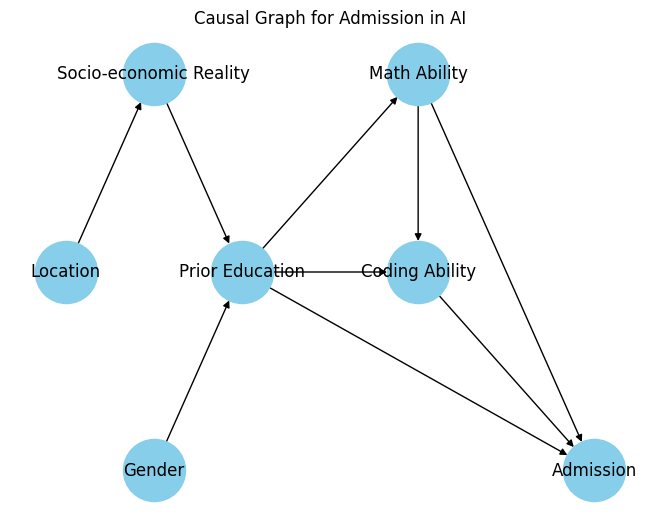

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

causal_graph = nx.DiGraph()

causal_graph.add_edges_from([
    ('Location', 'Socio-economic Reality'),
    ('Socio-economic Reality', 'Prior Education'),
    ('Gender', 'Prior Education'),
    ('Prior Education', 'Math Ability'),
    ('Prior Education', 'Coding Ability'),
    ('Math Ability', 'Coding Ability'),
    ('Math Ability', 'Admission'),
    ('Coding Ability', 'Admission'),
    ('Prior Education', 'Admission'),

])

# Specify positions for the nodes
pos = {
    'Location': (0, 0),
    'Socio-economic Reality': (1, 1),
    'Prior Education': (2, 0),
    'Math Ability': (4, 1),
    'Coding Ability': (4, 0),
    'Gender': (1, -1),
    'Admission': (6, -1)
}

# Plot the causal graph
nx.draw(causal_graph, pos,node_size=2000, node_color="skyblue",with_labels=True)
plt.title("Causal Graph for Admission in AI")
plt.show()



In [ ]:
!pip install pyro-ppl
!pip install causal-learn

#explaining the Assumptions

In the selection process for the Master's program in Artificial Intelligence at AIMS, we assume that African countries can be grouped into two categories: developed and underdeveloped countries. In these countries, socio-economic realities have different impacts on access to education.

The first reality is based on the notion that an individual is more likely to achieve a higher level of education when their family has a reasonable income to cover education expenses. The second reality is that, in these countries, girls often face challenges in accessing higher levels of education due to social norms, such as early marriages. After marriage, girls generally have fewer opportunities to pursue their studies.

Subsequently, we made assumptions about the capacity to acquire strong mathematical skills, depending on the subsequent level of education (assuming a focus on scientific and mathematical studies). Regarding coding skills, we assumed they depend on a high level of proficiency in mathematics since computer science departments are typically intertwined with mathematics departments.

In summary, we concluded that admission to AIMS IA primarily depends on the previous educational level. If a student does not meet the minimum requirements for a Master's program, they will automatically be rejected, regardless of their mathematical and coding skills. However, once at the Master's level, the selection process heavily relies on proficiency in mathematics and coding.

#Choice and sampling variables

## **Sampling gender**:

*The variable Sex is sampled from a Bernoulli distribution with a 60% probability of being assigned the value "Male" and a 40% probability of being assigned the value "Female."*

## **Sampling location**

*The variable Location is sampled from a categorical distribution, where there is a 70% chance of being assigned the value 0 (representing underdeveloped countries) and a 30% chance of being assigned the value 1 (representing developed countries).*

## **Sampling Socio economic reality**

*The variable Socio-economic Reality is sampled from a categorical distribution with three categories: low_income, mid_income, and high_income. The distribution is determined by the value of the Location variable. If Location is 0 (underdeveloped countries), the probabilities are [0.7, 0.2, 0.1]. If Location is 1 (developed countries), the probabilities are [0.2, 0.4, 0.4].*

## **Sampling the prior-education-level**

*The variable Prior_Education_level is sampled from a categorical distribution based on the values of Gender and Socio-economic Reality. In the provided example where Gender is 1 (male) and Socio-economic Reality is 0 (Underdevelopped countries), the probabilities are [0.3, 0.5, 0.2] those probabilities means a male from underdevelopped country issued from a low_incomed family have 30% to stop his studies in high school, 50% chance to do a bachelor and 20% chance to reach master. In our case the 3 categorical state [0 , 1 , 2] reprensente [high_school_level , Bachelor_level , master_level]*

##**Sampling Mathematics_ability**

*mathematics_ability is sampled from a normal distribution with a mean of 0.9 * prior_education_level. For example, if prior_education_level is 1, then the mean is 0.9, and a sample might be drawn as 1.05.*


## **Sampling coding_ability**

*coding_ability is sampled from a normal distribution with a mean of 0.7 * mathematics_ability. For example, if mathematics_ability is 1.05, a sample might be drawn as 0.735.*


*mathematics_ability and coding_ability are transformed using the sigmoid function to ensure they are probabilities between 0 and 1.*

##**Calculating the admission probabilities and sampling the admission**

*- admission_probs is calculated as 0.6 * mathematics_ability + 0.4 * coding_ability. For example, if mathematics_ability is 0.8 and coding_ability is 0.6, admission_probs might be calculated as 0.72.*

*-Based on the condition, if prior_education_level is 2 (Master_level) and admission_probs is greater than or equal to 0.7 (strong mat and coding abilities), then admission_probability is set to [0.2, 0.8]. Otherwise, it is set to [0.9, 0.1].*

*- Admission is sampled from a categorical distribution based on the calculated admission probabilities.those categorical state [1 , 0] represente [admitted , rejected]. For example, if admission_probs corresponds to [0.2, 0.8], a sample have a big chance to be drawn as 1 so accepted.*



In [34]:
import pyro
import pyro.distributions as dist
import torch
import pandas as pd

pyro.set_rng_seed(101)  # Setting a random seed for reproducibility

In [35]:
import pyro
import pyro.distributions as dist
from torch import tensor

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
def causal_model():
    # Variables and their distributions
    # Independent variables
    gender = pyro.sample('gender', dist.Bernoulli(0.6))
    location = pyro.sample('location', dist.Categorical(torch.tensor([0.7, 0.3])))

    # Variables dependent on others
    # Variable Socio_economic reality depends on location
    socio_economic_reality_probs = {
        0: torch.tensor([0.7, 0.2, 0.1]),
        1: torch.tensor([0.2, 0.4, 0.4])
    }
    socio_economic_reality = pyro.sample('socio_economic_reality', dist.Categorical(socio_economic_reality_probs[location.item()]))

    # Use a categorical distribution for prior_education_level
    prior_education_probs = {
      (0, 0): torch.tensor([0.6, 0.3, 0.1]),
      (0, 1): torch.tensor([0.4, 0.5, 0.1]),
      (0, 2): torch.tensor([0.2 ,0.6, 0.2]),
      (1, 0): torch.tensor([0.3, 0.5, 0.2]),
      (1, 1): torch.tensor([0.1, 0.2, 0.7]),
      (1, 2): torch.tensor([0.1, 0.4, 0.4]),

    }
    prior_education_level = pyro.sample('prior_education_level', dist.Categorical(prior_education_probs[(gender.item(), socio_economic_reality.item())]))


    # Use a normal distribution for mathematics_ability and coding_ability
    mathematics_ability = pyro.sample("mathematics_ability", dist.Normal(0.9 * prior_education_level , 0.1))
    coding_ability = pyro.sample('coding_ability', dist.Normal(0.6 * mathematics_ability , 0.1))

    # Apply sigmoid to transform the sampled values to valid probabilities
    mathematics_ability = sigmoid(mathematics_ability)
    coding_ability = sigmoid(coding_ability)

    # Admission probabilities
    admission_probs = 0.6 * mathematics_ability + 0.4 * coding_ability


    if prior_education_level.item() == 2 and admission_probs >= 0.7:
      admission_probabilty = torch.tensor([0.3 , 0.7])
    else :
      admission_probabilty = torch.tensor([0.9, 0.1])

    admission = pyro.sample('Admission', dist.Categorical(admission_probabilty))

    return {
        'location': location,
        'socio_economic_reality': socio_economic_reality,
        'gender': gender,
        'prior_education_level': prior_education_level,
        'mathematics_ability': mathematics_ability,
        'coding_ability': coding_ability,
        'Admission': admission
    }


# Structural Causal Model
## Gender

$ \text{gender} = f(\epsilon_{\text{gender}}) $


## Location

$ \text{location} = f(\epsilon_{\text{location}}) $

## Socio_economic_reality

$ \text{socio_economic_reality} = f(\text{location}, \epsilon_{\text{socio_economic_reality}}) $

## Prior_education_level

$ \text{prior_education_level} = f(\text{gender},  \text{socio_economic_reality}, \epsilon_{\text{prior_education_level}}) $

## Mathematics_ability

$ \text{mathematics_ability} = f(\text{prior_education_level}, \epsilon_{\text{mathematics_ability}}) $

## Coding_ability

$ \text{coding_ability} = f(\text{mathematics_ability}, \epsilon_{\text{coding_ability}}) $

$ \text{coding_ability} = f(\text{mathematics_ability}) + \epsilon_{\text{coding_ability}} $

## Admission

$ \text{admission} = f(\text{prior_education_level}, \text{mathematics_ability}, \text{coding_ability}, \epsilon_{\text{admission}}) $

$ \text{admission} = f(\text{prior_education_level}, \text{mathematics_ability}, \text{coding_ability}, \epsilon_{\text{admission}}) $

# Full Joint Distribution and Decomposition

$ P(\text{admission}|\text{gender}, \text{location}, \text{socio_economic_reality}, \text{prior_education_level}, \text{mathematics_ability}, \text{coding_ability}, ) = $ $ P(\text{gender}) \cdot P(\text{location}) \cdot P(\text{socio_economic_reality}|\text{location}) \cdot P(\text{prior_education_level}|\text{gender}, \text{socio_economic_reality}) \cdot P(\text{mathematics_ability}|\text{prior_education_level}) \cdot P(\text{coding_ability}|\text{mathematics_ability}, \text{prior_education_level}) \cdot P(\text{admission}|\text{prior_education_level}, \text{mathematics_ability}, \text{coding_ability}) $

# Backdoor Criterion:
There are backdoor paths from 'Prior Education' to 'Admission' through the variables 'Math Ability' and 'Coding Ability.'

Adjustment Sets:
To satisfy the backdoor criterion, adjusting for the set {'Mathematics_Ability', 'Coding_Ability'} would block the backdoor paths.

# confunders factors

'Mathematics_Ability' and 'Coding_Ability' are potential confounders for the relationship between 'Prior Education' and 'Admission.'

In [36]:
#converteing all the variables type for the generation of the data
types = {'mathematics_ability':float ,'coding_ability':float ,'gender':int ,'location':int , 'socio_economic_reality':int , 'prior_education_level':int ,'Admission':int}

In [37]:
def generate_data(num_samples):
    data = []
    for _ in range(num_samples):
        sample = causal_model()
        data.append(sample)
    return pd.DataFrame(data)

# Generate a synthetic dataset
synthetic_data = generate_data(10000)
synthetic_data =synthetic_data.astype(types)
# Display the first few rows of the generated data
synthetic_data.head(20)

,location,socio_economic_reality,gender,prior_education_level,mathematics_ability,coding_ability,Admission
0,0,2,1,0,0.491990,0.513633,0
1,0,0,0,0,0.514382,0.510161,0
2,0,0,0,1,0.723218,0.663830,0
3,0,1,1,2,0.842916,0.746210,0
4,1,2,0,0,0.466584,0.478385,0
5,1,2,0,1,0.697457,0.622853,0
6,0,0,1,0,0.512615,0.502364,0
7,0,0,1,0,0.524954,0.518784,0
8,0,0,1,1,0.718992,0.650557,0
9,1,2,1,2,0.866398,0.722956,1


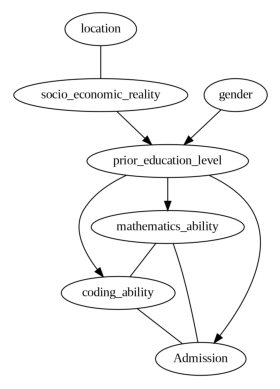

In [38]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(synthetic_data,node_names=['location',
                                        'socio_economic_reality',
                                        'gender' , 
                                        'prior_education_level',
                                        'mathematics_ability' ,
                                        'coding_ability', 
                                        'Admission'])

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()


# or save the graph
pyd.write_png('simple_test.png')




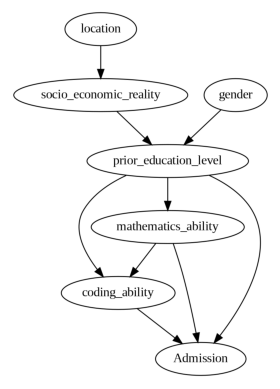

the hamming distance between my model and my predicted model : 4


In [39]:
from causallearn.graph.GeneralGraph import GeneralGraph
from causallearn.graph.SHD import SHD

nodes = Record['G'].nodes
est = Record['G']
truth_cpdag = GeneralGraph(nodes)

truth_cpdag.add_directed_edge(nodes[0], nodes[1])
truth_cpdag.add_directed_edge(nodes[1], nodes[3])
truth_cpdag.add_directed_edge(nodes[2], nodes[3])
truth_cpdag.add_directed_edge(nodes[3], nodes[4])
truth_cpdag.add_directed_edge(nodes[3], nodes[5])
truth_cpdag.add_directed_edge(nodes[3], nodes[6])
truth_cpdag.add_directed_edge(nodes[4], nodes[5])
truth_cpdag.add_directed_edge(nodes[4], nodes[6])
truth_cpdag.add_directed_edge(nodes[5], nodes[6])


pyd = GraphUtils.to_pydot(truth_cpdag )
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()
pyd.write_png('ogininal.png')
# Structural Hamming Distance
shd = SHD(truth_cpdag, est).get_shd()
print ("the hamming distance between my model and my predicted model :", shd )